In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(999)

Use models1.ipynb as a guide, but try some things on your own and see what you come up with!

Tools at your disposal:
*   ARIMA auto_arima
*   Regression
*   Variable transformations

Some ideas:

*   play with the clusters of countries (inlcude total # cases), try to hand pick a handful of countries that you think might go well together. (10 minimum) (European Countries, Germany, Spain, Italy...) 
*   Model fatalities?
*   Cummulative model (total cases to date)
 *   Cluster countries, get similar countries and build regression model with cummulative cases = population + ...








In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/Rishab2021/'
train_file = file_path + 'train.csv'
train = pd.read_csv(train_file)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
world_population = pd.read_csv("/content/drive/MyDrive/Rishab2021/population_by_country_2020.csv")

world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')
world_population = world_population.rename(columns={"Country (or dependency)": "Country"})

In [16]:
countries = ["Japan","Germany","Thailand", "United Kingdom","France","Italy","South Korea","Japan","Ukraine"]

In [17]:
US_updated_data = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
world_updated_data = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
world_updated_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,54403,54483,54559,54595,54672,54750,54854,54891,54939,55008,55023,55059,55121,55174,55231,55265,55330,55335,55359,55384,55402,55420,55445,55473,55492,55514,55518,55540,55557,55575,55580,55604,55617,55646,55664,55680,55696,55707,55714,55733
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,69916,70655,71441,72274,72812,73691,74567,75454,76350,77251,78127,78992,79934,80941,81993,83082,84212,85336,86289,87528,88671,89776,90835,91987,93075,93850,94651,95726,96838,97909,99062,100246,101285,102306,103327,104313,105229,106215,107167,107931
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,104852,105124,105369,105596,105854,106097,106359,106610,106887,107122,107339,107578,107841,108116,108381,108629,108629,109088,109313,109559,109782,110049,110303,110513,110711,110894,111069,111247,111418,111600,111764,111917,112094,112279,112461,112622,112805,112960,113092,113255
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9379,9416,9499,9549,9596,9638,9716,9779,9837,9885,9937,9972,10017,10070,10137,10172,10206,10251,10275,10312,10352,10391,10427,10463,10503,10538,10555,10583,10610,10645,10672,10699,10712,10739,10775,10799,10822,10849,10866,10889
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,19177,19269,19367,19399,19476,19553,19580,19672,19723,19782,19796,19829,19900,19937,19996,20030,20062,20086,20112,20163,20210,20261,20294,20329,20366,20381,20389,20400,20452,20478,20499,20519,20548,20584,20640,20695,20759,20782,20807,20854


In [18]:
cases2 = world_updated_data.melt(id_vars=["Province/State",	"Country/Region",	"Lat",	"Long"], 
                                 var_name="Date", 
                                 value_name="Cases").drop(["Lat","Long"],axis=1)
cases2.Date = pd.to_datetime(cases2.Date)
cases2 = cases2.sort_values(by=['Country/Region', 'Province/State', 'Date'])
# Subtract previous cases from current date. then drop 2020-01-22
cases2["lag_cases"] = cases2.Cases.shift(periods=1)
cases2["new_cases"] = cases2.Cases - cases2.lag_cases
cases2 = cases2[cases2.Date > "2020-03-01"].drop(["Cases", "lag_cases"], axis=1)
cases2.head()

,Province/State,Country/Region,Date,new_cases
10960,NaN,Afghanistan,2020-03-02,0.0
11234,NaN,Afghanistan,2020-03-03,1.0
11508,NaN,Afghanistan,2020-03-04,2.0
11782,NaN,Afghanistan,2020-03-05,0.0
12056,NaN,Afghanistan,2020-03-06,0.0


In [21]:
updated_all_data = cases2.merge(world_population, left_on='Country/Region', right_on='Country', how='inner')
updated_all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = updated_all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
updated_all_data = updated_all_data.rename(columns={"Land Area": "land_area", "Med Age": "med_age", "Urban Pop":"urban_pop", "Population (2020)":"Population"}).drop(["Country"],axis=1)
updated_all_data.head()

,Province/State,Country/Region,Date,new_cases,Population,Density,land_area,med_age,urban_pop
0,NaN,Afghanistan,2020-03-02,0.0,39074280,60,652860,18,25
1,NaN,Afghanistan,2020-03-03,1.0,39074280,60,652860,18,25
2,NaN,Afghanistan,2020-03-04,2.0,39074280,60,652860,18,25
3,NaN,Afghanistan,2020-03-05,0.0,39074280,60,652860,18,25
4,NaN,Afghanistan,2020-03-06,0.0,39074280,60,652860,18,25


In [22]:
countries = ["Japan","Germany","Thailand", "United Kingdom","France","Italy","Japan","Ukraine"] #"South Korea",
cases = updated_all_data[(updated_all_data["Country/Region"].isin(countries)) & (updated_all_data["Province/State"]).isna()]
cases.head()

,Province/State,Country/Region,Date,new_cases,Population,Density,land_area,med_age,urban_pop
44895,NaN,France,2020-03-02,61.0,65298930,119,547557,42,82
44896,NaN,France,2020-03-03,21.0,65298930,119,547557,42,82
44897,NaN,France,2020-03-04,73.0,65298930,119,547557,42,82
44898,NaN,France,2020-03-05,138.0,65298930,119,547557,42,82
44899,NaN,France,2020-03-06,190.0,65298930,119,547557,42,82


In [24]:
# !pip install pyramid.arima
# from pyramid.arima import auto_arima
!pip install pmdarima
import pmdarima as pm

     |████████████████████████████████| 1.5MB 5.1MB/s 
     |████████████████████████████████| 2.1MB 16.0MB/s 
     |████████████████████████████████| 9.5MB 30.7MB/s 
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [25]:
cases.loc[cases.new_cases < 0, 'new_cases'] = 0
train_df = cases[(cases.Date >= "2020-04-01") & (cases.Date <= "2021-02-01")]
test_df = cases[cases.Date > "2021-02-01"]
train_df["AA_out"] = -1
test_df["AA_out"] = -1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [26]:
train_df.head()

,Province/State,Country/Region,Date,new_cases,Population,Density,land_area,med_age,urban_pop,AA_out
44925,NaN,France,2020-04-01,4783.0,65298930,119,547557,42,82,-1
44926,NaN,France,2020-04-02,2042.0,65298930,119,547557,42,82,-1
44927,NaN,France,2020-04-03,5184.0,65298930,119,547557,42,82,-1
44928,NaN,France,2020-04-04,0.0,65298930,119,547557,42,82,-1
44929,NaN,France,2020-04-05,816.0,65298930,119,547557,42,82,-1


In [30]:
for c in countries:

  curr_train = train_df[train_df["Country/Region"] == c]
  curr_test = test_df[test_df["Country/Region"] == c]

  #AA = auto_arima(curr_train.TargetValue)
  AA = pm.auto_arima(curr_train.new_cases, start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                       start_P=0, seasonal=True, d=1, D=1, trace=True,
                       n_jobs=-1,  # We can run this in parallel by controlling this option
                       error_action='ignore',  # don't want to know if an order does not work
                       suppress_warnings=True,  # don't want convergence warnings
                       stepwise=False, random=True, random_state=42,  # we can fit a random search (not exhaustive)
                       n_fits=25)

  train_df.loc[train_df["Country/Region"] == c, 'AA_out'] = AA.predict_in_sample().tolist()
  test_df.loc[test_df["Country/Region"] == c, 'AA_out'] = AA.predict(n_periods = len(curr_test.new_cases)).tolist()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Best model:  ARIMA(2,1,0)(1,1,2)[12]          
Total fit time: 35.395 seconds


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes)


Best model:  ARIMA(0,1,1)(2,1,0)[12]          
Total fit time: 34.891 seconds


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes)


Best model:  ARIMA(3,1,0)(1,1,1)[12]          
Total fit time: 28.121 seconds


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes)


Best model:  ARIMA(0,1,1)(2,1,0)[12]          
Total fit time: 28.929 seconds


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes)


Best model:  ARIMA(0,1,3)(2,1,0)[12]          
Total fit time: 15.974 seconds


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes)


Best model:  ARIMA(0,1,3)(2,1,0)[12]          
Total fit time: 29.188 seconds


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes)


Best model:  ARIMA(2,1,0)(1,1,2)[12]          
Total fit time: 28.031 seconds


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes)


Best model:  ARIMA(2,1,2)(1,1,0)[12]          
Total fit time: 33.147 seconds


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [31]:
train_df.head()

,Province/State,Country/Region,Date,new_cases,Population,Density,land_area,med_age,urban_pop,AA_out
44925,NaN,France,2020-04-01,4783.0,65298930,119,547557,42,82,0.000000
44926,NaN,France,2020-04-02,2042.0,65298930,119,547557,42,82,2934.613428
44927,NaN,France,2020-04-03,5184.0,65298930,119,547557,42,82,1401.672246
44928,NaN,France,2020-04-04,0.0,65298930,119,547557,42,82,3561.570993
44929,NaN,France,2020-04-05,816.0,65298930,119,547557,42,82,1554.675527


In [32]:
import statsmodels.formula.api as sm
reg_full = sm.ols('new_cases ~ Population + Density + land_area + med_age + urban_pop + AA_out', data=train_df).fit()
reg_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     1594.
Date:                Wed, 03 Mar 2021   Prob (F-statistic):               0.00
Time:                        02:50:08   Log-Likelihood:                -21130.
No. Observations:                2149   AIC:                         4.227e+04
Df Residuals:                    2142   BIC:                         4.231e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7714.3673   4085.141      1.888      0.059    -296.889    1.57e+04
Population  3.394e-05   2.93e-05      1.158      0.247   -2.36e-05    9.14e-05
Density      -22.3148     12.844     -1.737      0.082     -47.503       2.873
land_area     -0.0114      0.006     -1.993      0.046      -0.023      -0.000
med_age      -89.7319     56.044     -1.601      0.110    -199.638      20.174
urban_pop     47.1996     15.023      3.142      0.002      17.738      76.661
AA_out         0.8862      0.010     87.542      0.000       0.866       0.906
==============================================================================
Omnibus:                     1094.991   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           149603.458
Skew:                           1.371   Prob(JB):                         0.00
Kurtosis:                      43.783   Cond. No.                     3.26e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# Reduced model if needed
import statsmodels.api as sm1
reg_reduced = sm.ols('new_cases ~ land_area + urban_pop + AA_out', data=train_df).fit()
sm1.stats.anova_lm(reg_reduced,reg_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2145.0,4.397519e+10,0.0,NaN,NaN,NaN
1,2142.0,4.367774e+10,3.0,2.974479e+08,4.86238,0.002254


In [34]:
US_updated_data.head()
#us_cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5270,5327,5358,5376,5407,5440,5499,5554,5596,5596,5669,5683,5723,5753,5811,5824,5856,5869,5881,5910,5930,5970,5984,6002,6023,6024,6038,6050,6071,6079,6092,6117,6121,6143,6172,6203,6228,6248,6264,6270
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16798,16981,17128,17256,17333,17496,17629,17779,17922,17922,18126,18211,18344,18418,18494,18568,18668,18723,18763,18824,18888,18960,18994,19051,19105,19136,19176,19267,19324,19361,19392,19433,19461,19554,19635,19670,19698,19714,19732,19758
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1778,1793,1805,1827,1834,1882,1898,1920,1931,1931,1951,1956,1966,1981,1989,1994,2002,2008,2008,2019,2024,2030,2036,2040,2042,2044,2055,2053,2057,2061,2067,2070,2074,2084,2095,2099,2106,2113,2115,2116
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2198,2212,2223,2223,2229,2247,2261,2271,2284,2284,2307,2309,2319,2321,2327,2331,2334,2339,2346,2362,2368,2377,2385,2393,2395,2397,2400,2399,2405,2411,2414,2416,2417,2432,2437,2442,2445,2449,2450,2450
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5411,5439,5462,5473,5485,5517,5568,5612,5655,5655,5713,5720,5745,5768,5842,5871,5908,5915,5920,5929,5937,5955,5953,5957,5961,5973,5987,5997,6008,6021,6040,6042,6043,6058,6072,6086,6084,6095,6097,6102


In [35]:
us_cases = US_updated_data.melt(id_vars=["Province_State",	"Country_Region",	"Lat",	"Long_", "Combined_Key",
                                         "UID", "iso2", "iso3", "code3", "FIPS", "Admin2"], 
                                 var_name="Date", 
                                 value_name="Cases").drop(["Lat", "Long_", "UID", "iso2",
                                                           "iso3", "code3", "FIPS", "Combined_Key"],axis=1)
us_cases.Date = pd.to_datetime(us_cases.Date)
us_cases = us_cases.sort_values(by=['Country_Region', 'Province_State', "Admin2", 'Date'])
# Subtract previous cases from current date. then drop 2020-01-22
us_cases["lag_cases"] = us_cases.Cases.shift(periods=1)
us_cases["new_cases"] = us_cases.Cases - us_cases.lag_cases
us_cases = us_cases[us_cases.Date > "2020-03-01"].drop(["Cases", "lag_cases"], axis=1)
us_cases.head()

,Province_State,Country_Region,Admin2,Date,new_cases
133600,Alabama,US,Autauga,2020-03-02,0.0
136940,Alabama,US,Autauga,2020-03-03,0.0
140280,Alabama,US,Autauga,2020-03-04,0.0
143620,Alabama,US,Autauga,2020-03-05,0.0
146960,Alabama,US,Autauga,2020-03-06,0.0


In [36]:
## This next part will ake a little while to fit all the models.

from datetime import datetime, timedelta
# Find some places where we get good predictions. 
c = "US"


# grab the data you want 
#c_cases = us_cases[(us_cases.Country_Region == "US") & (us_cases.Province_State == c)] # When you want a specific state
c_cases = cases2[(cases2["Country/Region"] == c) & (cases2["Province/State"].isna())] # When you want to plot a country


# First create a new series for the predictions. intialize to NaN
c_cases["preds"] = np.nan

# Need to group by date to get all cases state-wide.
c_cases = c_cases.groupby(['Date']).sum().reset_index()
c_cases.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,new_cases,preds
360,2021-02-25,77291.0,0.0
361,2021-02-26,76791.0,0.0
362,2021-02-27,64287.0,0.0
363,2021-02-28,51205.0,0.0
364,2021-03-01,58810.0,0.0


In [37]:
# loop time periods
# Turn off warnings to make output cleaner
import warnings
warnings.filterwarnings('ignore')


start = c_cases.Date.min()
end = c_cases.Date.max()
train_end = start + timedelta(days=28)

while train_end < end:
  train_df = c_cases[(c_cases.Date >= start) & (c_cases.Date <= train_end)] # Define training data
  test_df = c_cases[(c_cases.Date >= train_end) & (c_cases.Date <= train_end + timedelta(days=6))] # Get next week of data
  
  # start = train_end - timedelta(days=28) # if you only want to train on the past 28 days. 
  # Fit ARIMA model   
  #AA = auto_arima(train_df.TargetValue) # fit auto_arima model
  AA = pm.auto_arima(train_df.new_cases, start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                       start_P=0, seasonal=True, d=1, D=1, trace=True,
                       n_jobs=-1,  # We can run this in parallel by controlling this option
                       error_action='ignore',  # don't want to know if an order does not work
                       suppress_warnings=True,  # don't want convergence warnings
                       stepwise=False, random=True, random_state=42,  # we can fit a random search (not exhaustive)
                       n_fits=25)
  # Make prediction for next week (or so)
  c_cases.preds[(c_cases.Date >= train_end) & (c_cases.Date <= train_end + timedelta(days=6))] = AA.predict(n_periods=len(test_df.new_cases)).tolist()
  train_end = min([train_end + timedelta(days=7), end]) # Set new cutoff for training data (next iteration)
  print("Through ", str(train_end))
  


Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 6.754 seconds
Through  2020-04-06 00:00:00

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 4.669 seconds
Through  2020-04-13 00:00:00

Best model:  ARIMA(0,1,1)(1,1,0)[12]          
Total fit time: 8.376 seconds
Through  2020-04-20 00:00:00

Best model:  ARIMA(0,1,1)(2,1,0)[12]          
Total fit time: 8.299 seconds
Through  2020-04-27 00:00:00

Best model:  ARIMA(0,1,1)(2,1,0)[12]          
Total fit time: 8.734 seconds
Through  2020-05-04 00:00:00

Best model:  ARIMA(0,1,1)(2,1,0)[12]          
Total fit time: 10.305 seconds
Through  2020-05-11 00:00:00

Best model:  ARIMA(0,1,1)(2,1,0)[12]          
Total fit time: 10.439 seconds
Through  2020-05-18 00:00:00

Best model:  ARIMA(0,1,1)(2,1,0)[12]          
Total fit time: 12.236 seconds
Through  2020-05-25 00:00:00

Best model:  ARIMA(0,1,1)(2,1,0)[12]          
Total fit time: 11.534 seconds
Through  2020-06-01 00:00:00

Best model:  ARIMA(0,1,1)(2,1,0)

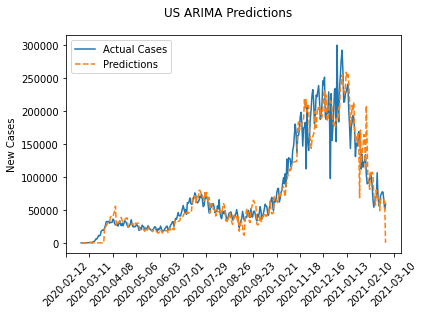

In [38]:
# Initializes plot objects
fig, ax = plt.subplots()
# Plot line for actual values
ax.plot(c_cases.Date,c_cases.new_cases,label="Actual Cases")
# Overlay Line for Predicted Values
ax.plot(c_cases.Date, c_cases.preds,linestyle='dashed', label='Predictions')
# Changes the axes tick marks and angle.
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 28))
ax.tick_params(axis='x', labelrotation = 45)
ax.legend(loc="upper left")
plt_title = c + " ARIMA Predictions"
fig.suptitle(plt_title)
#fig.tight_layout()
plt.ylabel("New Cases")
plt.show()


In [ ]:
# Save figure to the drive folder as [Country]_ARIMA_PREDS.jpg
file_to_save = file_path + c + "_ARIMA_PREDS.jpg"
fig.savefig(file_to_save, bbox_inches = "tight")